In [1]:
import models, data, loss, train, sampling
from matplotlib import pyplot as plt
import torch as t
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


# Dataset Creation and Visualization

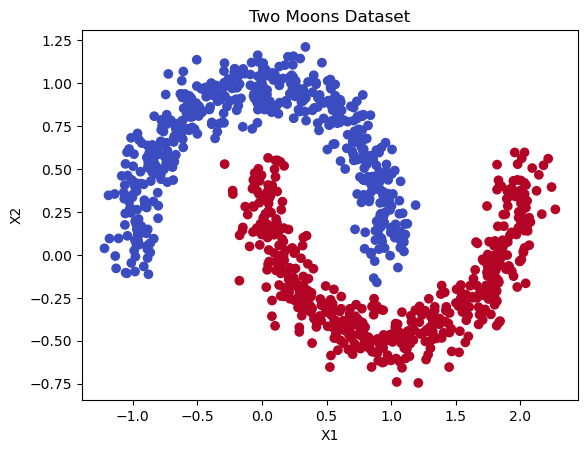

In [2]:
moonsDS = data.MoonsDataset(n_samples=1000, noise=0.1)

# scatter plot of the dataset
plt.scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, cmap='coolwarm')
plt.title("Two Moons Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

# Dataset Creation with train-test split

In [3]:
trainDS = data.MoonsDataset(n_samples=100000, noise=0.1)
testDS = data.MoonsDataset(n_samples=10000, noise=0.1)

# Training a traditional classifier MLP

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

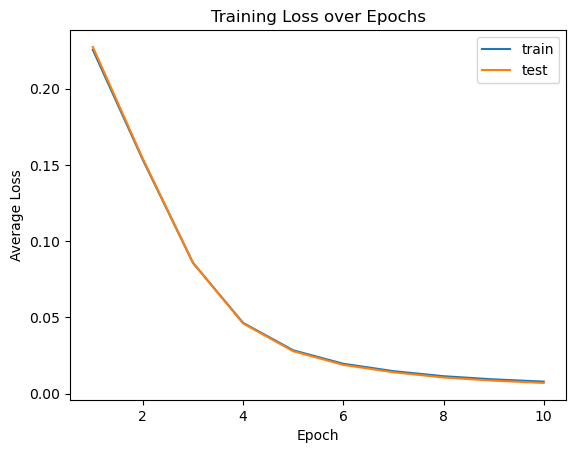

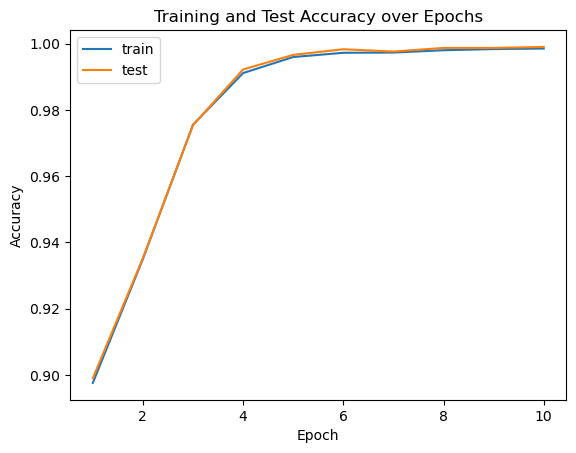

In [4]:
# Hyperparameters
h_dim = 16
lr = 1e-3
device = t.device("cuda" if t.cuda.is_available() else "cpu")
epochs = 10

trad_clf = models.MLP(x_dim=2, hidden_dim=h_dim, y_dim=2)
loss_fn = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(trad_clf.parameters(), lr=lr)
training = train.Training(model=trad_clf,optim=optimizer,loss_fn=loss_fn,device=device)
train_loader = DataLoader(trainDS, batch_size=128, shuffle=True)
test_loader = DataLoader(testDS, batch_size=128, shuffle=False)

train_loss = []
test_loss = []
train_metrics = []
test_metrics = []
progress_bar = tqdm(range(epochs), desc="Training Progress")
for epoch in progress_bar:
    training.train_epoch(train_loader)
    
    tr_loss, tr_metrics = training.evaluate(train_loader)
    te_loss, te_metrics = training.evaluate(test_loader)
    
    train_loss.append(tr_loss)
    test_loss.append(te_loss)
    train_metrics.append(tr_metrics)
    test_metrics.append(te_metrics)
    
    progress_bar.set_postfix(train_loss=f"{tr_loss:.4f}", test_loss=f"{te_loss:.4f}")

# Plot training/test loss
plt.plot(range(1, epochs+1), train_loss, label='train')
plt.plot(range(1, epochs+1), test_loss, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss over Epochs")
plt.show()

# Plot training/ test accuracy
plt.plot(range(1, epochs+1), [m['accuracy'] for m in train_metrics], label='train')
plt.plot(range(1, epochs+1), [m['accuracy'] for m in test_metrics], label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.show()


# Visualizing the softmax outputs

/Users/simon/miniconda3/envs/flow_matching/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729647058851/work/aten/src/ATen/native/TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


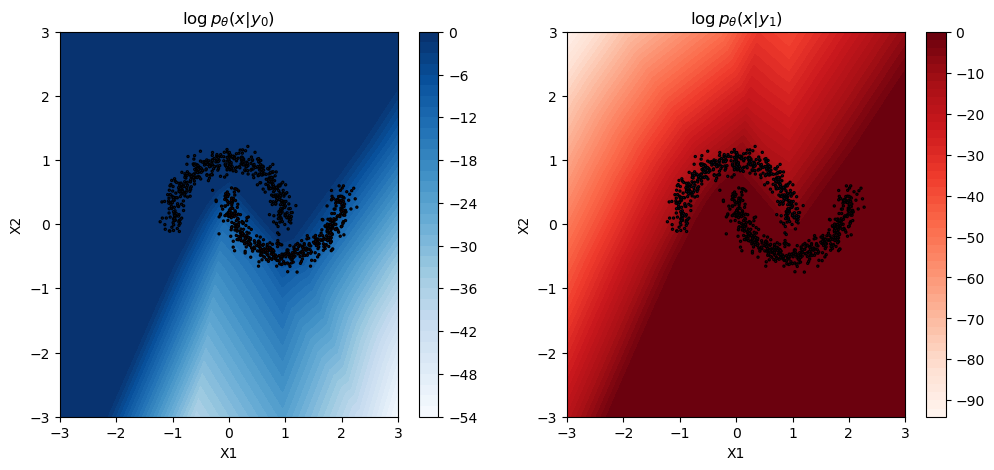

In [5]:
xlims = np.array([[-3,3],[-3,3]])
npoints = 1000

X = t.meshgrid(t.linspace(xlims[0,0],xlims[0,1],npoints),t.linspace(xlims[0,0],xlims[0,1],npoints))
grid = t.stack([X[0].reshape(-1), X[1].reshape(-1)], dim=1).to(device)
with t.no_grad():
    logits = trad_clf(grid)
    log_probs = t.log(t.softmax(logits,dim=1))
log_p_x_given_y = log_probs.cpu().reshape(npoints,npoints,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
titles = [r"$\log p_\theta(x|y_0)$", r"$\log p_\theta(x|y_1)$"]
cmaps = ['Blues', 'Reds']
for i in range(2):
    cs = ax[i].contourf(X[0], X[1], log_p_x_given_y[:,:,i], levels=50, cmap=cmaps[i])
    fig.colorbar(cs, ax=ax[i])
    ax[i].scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, edgecolor='k', s=2, cmap='coolwarm', alpha=1)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("X1")
    ax[i].set_ylabel("X2")
plt.show()

# Visualizing the learned unnormalized joint distribution $\log p_\theta(x,y)$

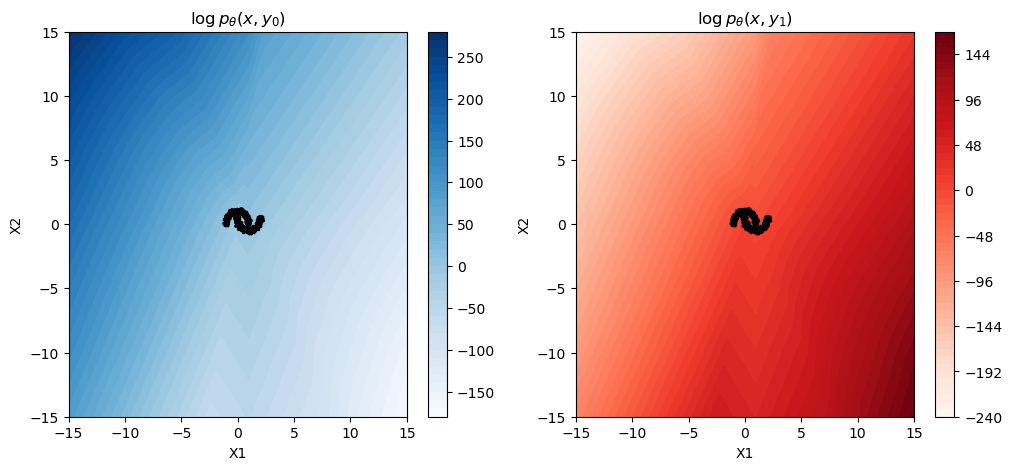

In [6]:
xlims = np.array([[-15,15],[-15,15]])
npoints = 1000

X = t.meshgrid(t.linspace(xlims[0,0],xlims[0,1],npoints),t.linspace(xlims[0,0],xlims[0,1],npoints))
grid = t.stack([X[0].reshape(-1), X[1].reshape(-1)], dim=1).to(device)
with t.no_grad():
    logits = trad_clf(grid)
    log_probs = logits
log_p_xy = log_probs.cpu().reshape(npoints,npoints,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
titles = [r"$\log p_\theta(x,y_0)$", r"$\log p_\theta(x,y_1)$"]
cmaps = ['Blues', 'Reds']
for i in range(2):
    cs = ax[i].contourf(X[0], X[1], log_p_xy[:,:,i], levels=50, cmap=cmaps[i])
    fig.colorbar(cs, ax=ax[i])
    ax[i].scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, edgecolor='k', s=2, cmap='coolwarm', alpha=1)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("X1")
    ax[i].set_ylabel("X2")
plt.show()


# Visualizing the unnormalized marginal distribution $\log p_\theta(x)$

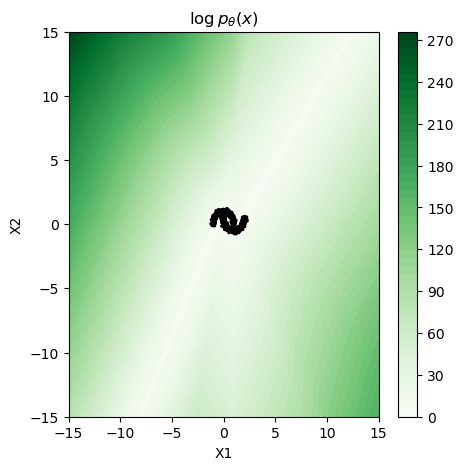

In [7]:
xlims = np.array([[-15,15],[-15,15]])
npoints = 1000

X = t.meshgrid(t.linspace(xlims[0,0],xlims[0,1],npoints),t.linspace(xlims[0,0],xlims[0,1],npoints))
grid = t.stack([X[0].reshape(-1), X[1].reshape(-1)], dim=1).to(device)
with t.no_grad():
    logits = trad_clf(grid)
    log_probs = t.logsumexp(logits,axis=-1)
log_p_x = log_probs.cpu().reshape(npoints,npoints)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
titles = [r"$\log p_\theta(x)$"]
cmaps = ['Greens']
for i in range(1):
    cs = ax.contourf(X[0], X[1], log_p_x[:,:], levels=50, cmap=cmaps[i])
    fig.colorbar(cs, ax=ax)
    ax.scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, edgecolor='k', s=2, cmap='coolwarm', alpha=1)
    ax.set_title(titles[i])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
plt.show()


# Visualizing the conditional distributions $p_\theta(y|x) = \frac{p_\theta(x,y)}{p_\theta(x)}$

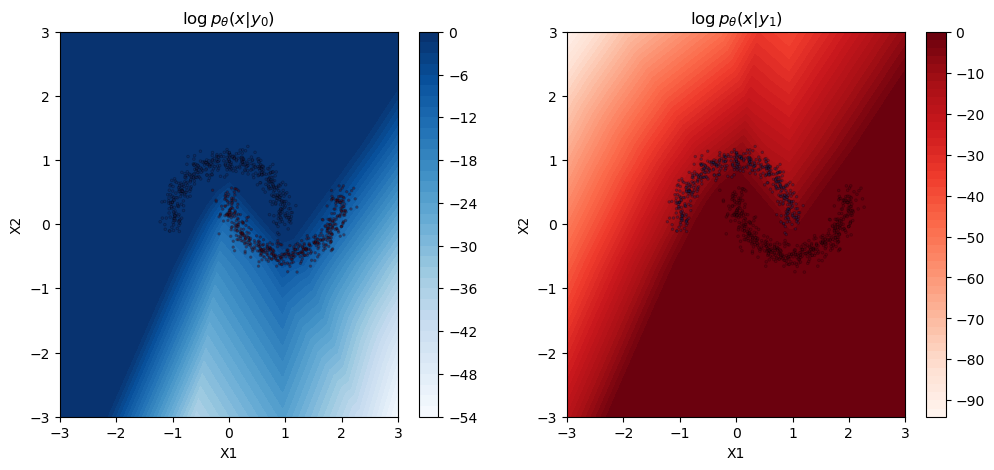

In [8]:
xlims = np.array([[-3,3],[-3,3]])
npoints = 1000

X = t.meshgrid(t.linspace(xlims[0,0],xlims[0,1],npoints),t.linspace(xlims[0,0],xlims[0,1],npoints))
grid = t.stack([X[0].reshape(-1), X[1].reshape(-1)], dim=1).to(device)
with t.no_grad():
    logits = trad_clf(grid)
    log_probs_xy = logits
    log_probs_x = t.logsumexp(logits,keepdim=True,axis=-1)    #t.sum(probs_xy,axis=-1,keepdim=True)
    log_probs = log_probs_xy - log_probs_x
log_p_x_given_y = log_probs.cpu().reshape(npoints,npoints,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
titles = [r"$\log p_\theta(x|y_0)$", r"$\log p_\theta(x|y_1)$"]
cmaps = ['Blues', 'Reds']
for i in range(2):
    cs = ax[i].contourf(X[0], X[1], log_p_x_given_y[:,:,i], levels=50, cmap=cmaps[i])
    fig.colorbar(cs, ax=ax[i])
    ax[i].scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, edgecolor='k', s=2, cmap='coolwarm', alpha=.3)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("X1")
    ax[i].set_ylabel("X2")
plt.show()

# Train a JEM model

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

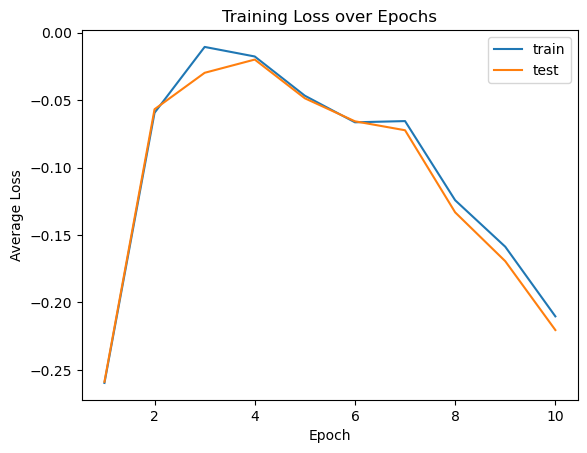

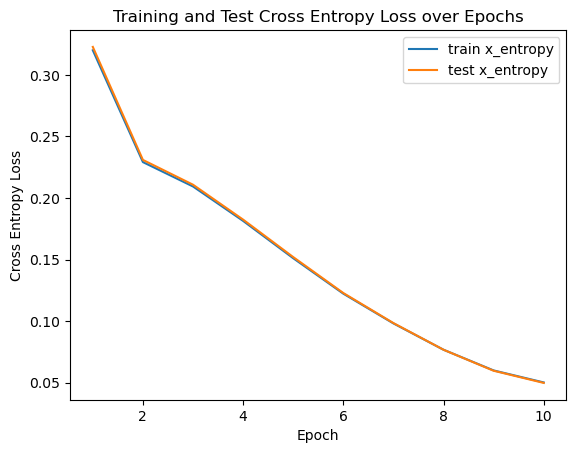

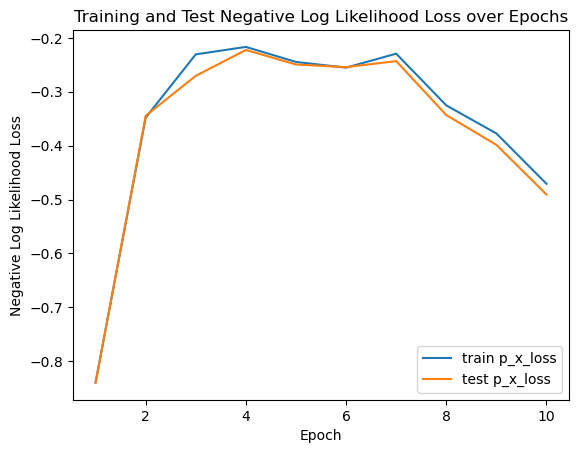

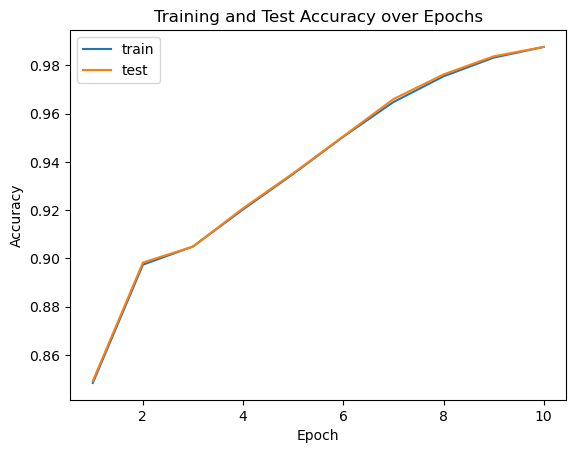

In [9]:
# Hyperparameters
h_dim = 16
lr = 1e-3
device = t.device("cuda" if t.cuda.is_available() else "cpu")
epochs = 10 
sampling_steps = 50
sampling_bs = 256
lam = 0.5 

jem = models.MLP(x_dim=2, hidden_dim=h_dim, y_dim=2)
sampler = sampling.SGLD(model=jem,batch_size=sampling_bs,domain_dims=2,device=device,init_strategy="uniform",init_params=(-3,3))
loss_fn = loss.PxYLoss(sgld=sampler,lam=lam)
optimizer = t.optim.Adam(jem.parameters(), lr=lr)
training = train.JEM_Training(model=jem,optim=optimizer,loss_fn=loss_fn,device=device)
train_loader = DataLoader(trainDS, batch_size=128, shuffle=True)
test_loader = DataLoader(testDS, batch_size=128, shuffle=False)

train_loss = []
train_x_entropy = []
train_p_x_loss = []
test_loss = []
test_x_entropy = []
test_p_x_loss = []
train_metrics = []
test_metrics = []
progress_bar = tqdm(range(epochs), desc="Training Progress")
for epoch in progress_bar:
    training.train_epoch(train_loader)
    
    tr_loss, tr_x_entropy, tr_p_x_loss, tr_metrics = training.evaluate(train_loader)
    te_loss, te_x_entropy, te_p_x_loss, te_metrics = training.evaluate(test_loader)
    
    train_loss.append(tr_loss)
    train_x_entropy.append(tr_x_entropy)
    train_p_x_loss.append(tr_p_x_loss)
    test_loss.append(te_loss)
    test_x_entropy.append(te_x_entropy)
    test_p_x_loss.append(te_p_x_loss)
    train_metrics.append(tr_metrics)
    test_metrics.append(te_metrics)
    
    progress_bar.set_postfix(train_loss=f"{tr_loss:.4f}", test_loss=f"{te_loss:.4f}")

# Plot training/test loss
plt.plot(range(1, epochs+1), train_loss, label='train')
plt.plot(range(1, epochs+1), test_loss, label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss over Epochs")
plt.show()

# Plot training/test x_entropy
plt.plot(range(1, epochs+1), train_x_entropy, label='train x_entropy')
plt.plot(range(1, epochs+1), test_x_entropy, label='test x_entropy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training and Test Cross Entropy Loss over Epochs")
plt.show()

# Plot training/test p_x_loss
plt.plot(range(1, epochs+1), train_p_x_loss, label='train p_x_loss')
plt.plot(range(1, epochs+1), test_p_x_loss, label='test p_x_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Negative Log Likelihood Loss")
plt.title("Training and Test Negative Log Likelihood Loss over Epochs")
plt.show()

# Plot training/ test accuracy
plt.plot(range(1, epochs+1), [m['accuracy'] for m in train_metrics], label='train')
plt.plot(range(1, epochs+1), [m['accuracy'] for m in test_metrics], label='test')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.show()



# Visualize the learned unnormalized joint distribution $Z(\theta) p_\theta(x,y)$

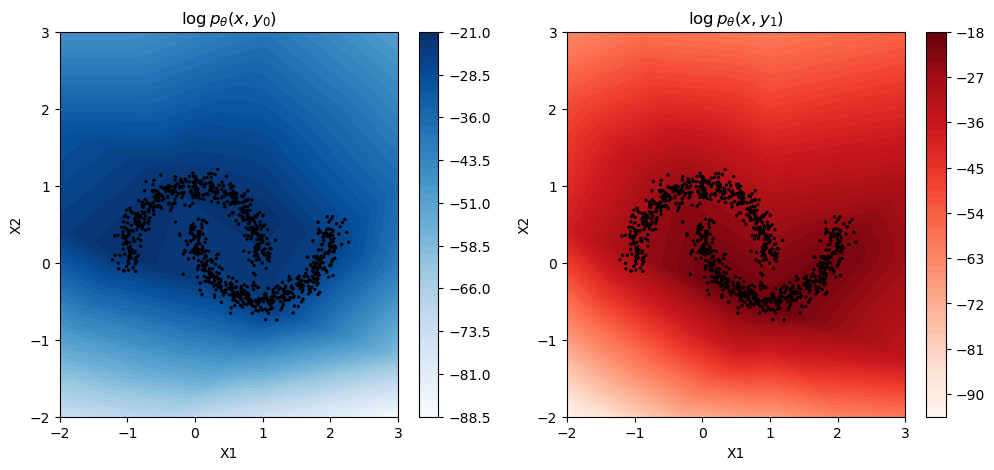

In [10]:
xlims = np.array([[-2,3],[-2,2]])
npoints = 1000

X = t.meshgrid(t.linspace(xlims[0,0],xlims[0,1],npoints),t.linspace(xlims[0,0],xlims[0,1],npoints))
grid = t.stack([X[0].reshape(-1), X[1].reshape(-1)], dim=1).to(device)
with t.no_grad():
    logits = jem(grid)
    log_probs = logits
log_p_xy = log_probs.cpu().reshape(npoints,npoints,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
titles = [r"$\log p_\theta(x,y_0)$", r"$\log p_\theta(x,y_1)$"]
cmaps = ['Blues', 'Reds']
for i in range(2):
    cs = ax[i].contourf(X[0], X[1], log_p_xy[:,:,i], levels=50, cmap=cmaps[i])
    fig.colorbar(cs, ax=ax[i])
    ax[i].scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, edgecolor='k', s=2, cmap='coolwarm', alpha=1)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("X1")
    ax[i].set_ylabel("X2")
plt.show()

# Visualizing the unnormalized marginal distribution $Z(\theta)p_\theta(x)$

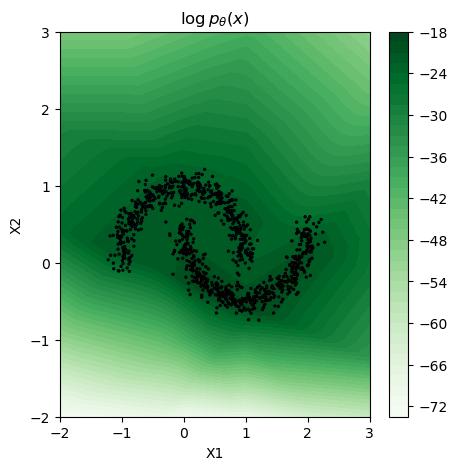

In [11]:
xlims = np.array([[-2,3],[-2,2]])
npoints = 1000

X = t.meshgrid(t.linspace(xlims[0,0],xlims[0,1],npoints),t.linspace(xlims[0,0],xlims[0,1],npoints))
grid = t.stack([X[0].reshape(-1), X[1].reshape(-1)], dim=1).to(device)
with t.no_grad():
    logits = jem(grid)
    log_probs = t.logsumexp(logits,axis=-1)
log_p_x = log_probs.cpu().reshape(npoints,npoints)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
titles = [r"$\log p_\theta(x)$"]
cmaps = ['Greens']
for i in range(1):
    cs = ax.contourf(X[0], X[1], log_p_x[:,:], levels=50, cmap=cmaps[i])
    fig.colorbar(cs, ax=ax)
    ax.scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, edgecolor='k', s=2, cmap='coolwarm', alpha=1)
    ax.set_title(titles[i])
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
plt.show()


# Visualizing the conditional distributions $p_\theta(y|x) = \frac{p_\theta(x,y)}{p_\theta(x)}$

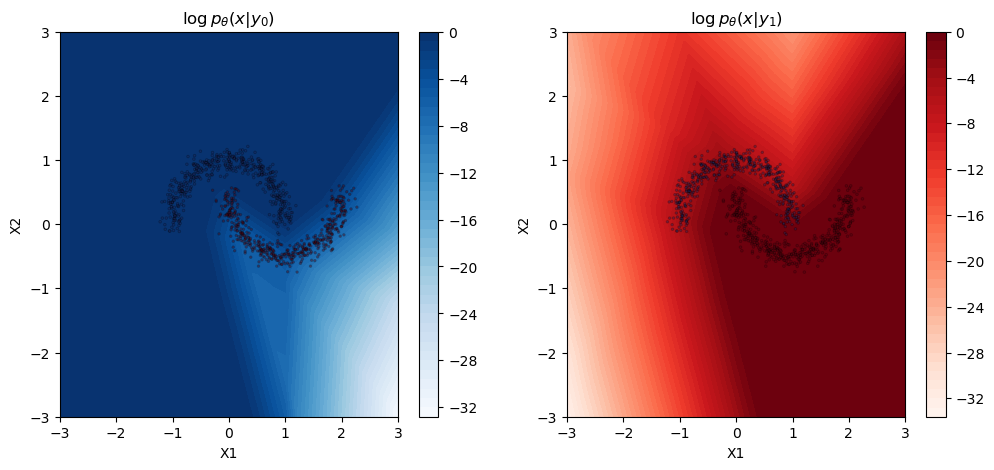

In [12]:
xlims = np.array([[-3,3],[-3,3]])
npoints = 1000

X = t.meshgrid(t.linspace(xlims[0,0],xlims[0,1],npoints),t.linspace(xlims[0,0],xlims[0,1],npoints))
grid = t.stack([X[0].reshape(-1), X[1].reshape(-1)], dim=1).to(device)
with t.no_grad():
    logits = jem(grid)
    log_probs_xy = logits
    log_probs_x = t.logsumexp(log_probs_xy,axis=-1,keepdim=True)
    log_probs = log_probs_xy - log_probs_x
log_p_x_given_y = log_probs.cpu().reshape(npoints,npoints,2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
titles = [r"$\log p_\theta(x|y_0)$", r"$\log p_\theta(x|y_1)$"]
cmaps = ['Blues', 'Reds']
for i in range(2):
    cs = ax[i].contourf(X[0], X[1], log_p_x_given_y[:,:,i], levels=50, cmap=cmaps[i])
    fig.colorbar(cs, ax=ax[i])
    ax[i].scatter(moonsDS.X[:,0], moonsDS.X[:,1], c=moonsDS.y, edgecolor='k', s=2, cmap='coolwarm', alpha=.3)
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("X1")
    ax[i].set_ylabel("X2")
plt.show()